In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [32]:
df_wine = pd.read_csv('winequality-red.csv', sep=';')
df_wine.loc[:, 'quality_cat'] = (df_wine.quality > 5).astype(int)
df_wine = df_wine.drop('quality', axis=1)
X = df_wine.iloc[:, :-1].values
y = df_wine.iloc[:, -1].values
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [33]:
X

array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
       [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]])

### PCA из коробки (тупо импортируем из sklearn)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(X)

PCA(n_components=6)

In [35]:
Z = pca.transform(X)
Z[:3]

array([[-13.22490501,  -2.02389981,  -1.12682053,  -0.39923318,
         -1.08538902,  -0.19801755],
       [ 22.03772361,   4.40832155,  -0.31037799,  -0.19993774,
         -0.55710939,  -0.30132496],
       [  7.16267333,  -2.50146086,  -0.5818683 ,  -0.21906928,
         -0.55293355,  -0.20511367]])

### PCA через SVD разложение

In [39]:
X_ = X - X.mean(axis=0)
from numpy.linalg import svd
u, s, vt = svd(X_)
S = np.diag(s)
# X_svd = u.dot(S).dot(vt)
# X_svd

In [41]:
v = vt[:6, :].T
v
Z_svd = X_.dot(v)
Z_svd[:3]

array([[ 13.22490501,  -2.02389981,   1.12682053,   0.39923318,
          1.08538902,   0.19801755],
       [-22.03772361,   4.40832155,   0.31037799,   0.19993774,
          0.55710939,   0.30132496],
       [ -7.16267333,  -2.50146086,   0.5818683 ,   0.21906928,
          0.55293355,   0.20511367]])

### Через матрицу ковариаций

In [51]:
from numpy.linalg import eig
C = X_.T.dot(X_)
lambd, W = eig(C)

In [43]:
lambd/lambd.sum()

array([9.46576976e-01, 4.83683046e-02, 2.58917183e-03, 1.51896798e-03,
       8.73553990e-04, 3.45607218e-05, 1.93627614e-05, 9.47278079e-06,
       8.41376628e-06, 1.21472798e-06, 4.68762788e-10])

In [49]:
pca.explained_variance_ratio_

array([9.46576976e-01, 4.83683046e-02, 2.58917183e-03, 1.51896798e-03,
       8.73553990e-04, 3.45607218e-05])

### Влияние количества компонент на качество

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [53]:
model_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [55]:
base_score = cross_val_score(model_baseline, X, y, scoring='accuracy', cv=cv).mean()

In [56]:
base_score

0.7398138714733543

In [57]:
k = range(1, 12)
scores = []

for n in k:
    model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n)),
    ('clf', LogisticRegression())
])
    scores.append(cross_val_score(model, X, y, scoring='accuracy', cv=cv).mean())

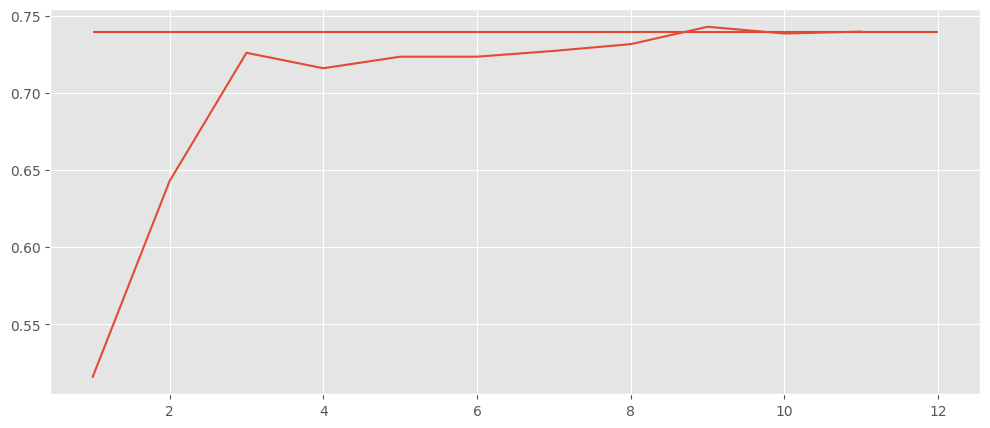

In [58]:
plt.plot(k, scores)
plt.hlines(base_score, 1, 12)